In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import geopandas as gpd
import unicodedata
from shapely.affinity import translate, scale


In [2]:
codigos_escolas_distritos = pd.read_parquet("data_parquet/codigos_escolas_distritos.parquet")
escolas = pd.read_parquet("data_parquet/inflacao_escolas_res.parquet")
escolas_anos = pd.read_parquet("data_parquet/inflacao_escolas_anos_res.parquet")
disciplina = pd.read_parquet("data_parquet/inflacao_disciplina_res.parquet")
disciplina_anos = pd.read_parquet("data_parquet/inflacao_disciplina_anos_res.parquet")


In [3]:
codigos_escolas_distritos.head()
#escolas.head()

,escola,escola_descr,escola_distrito,escola_distrito_descr,escola_concelho,escola_concelho_descr,escola_pubpriv
0,2,Escola BÃ¡sica e SecundÃ¡ria de Michel Giacome...,15.0,SetÃºbal,11.0,Sesimbra,PUB
1,31,Escola BÃ¡sica e SecundÃ¡ria Dr. JoÃ£o Brito C...,2.0,Beja,2.0,AlmodÃ´var,PUB
2,39,Escola BÃ¡sica e SecundÃ¡ria de Ourique,2.0,Beja,12.0,Ourique,PUB
3,47,Escola BÃ¡sica e SecundÃ¡ria de Cabeceiras de ...,3.0,Braga,4.0,Cabeceiras de Basto,PUB
4,49,Escola BÃ¡sica e SecundÃ¡ria de Celorico de Basto,3.0,Braga,5.0,Celorico de Basto,PUB


# Useful functions

In [4]:
def mean_and_standard_deviation_from_samples(means, stdevs, nsamples):
    N = np.sum(nsamples)
    mean = np.sum(means * nsamples) / N
    variance = 1/(N-1)*(np.sum(nsamples * (stdevs**2 + means**2))-np.sum(stdevs**2) - N*mean**2)
    return mean, np.sqrt(variance)

def agg_func(group):
    mean, std = mean_and_standard_deviation_from_samples(group["INF_RESIDUAL"], group["INF_RESIDUAL_STD"], group["NSAMPLES"])
    return pd.Series({"INF_RESIDUAL": mean, "INF_RESIDUAL_STD": std, "NSAMPLES": np.sum(group["NSAMPLES"])})

# 1 - Públicas vs Privadas

In [5]:
# add PUB PRIV to set using codigos

escolas_det = escolas.merge(codigos_escolas_distritos, left_on="ESCOLA", right_on="escola", how="left", validate="one_to_one")

In [6]:
escolas_det.head()

,ESCOLA,INF_RESIDUAL,INF_RESIDUAL_STD,NSAMPLES,escola,escola_descr,escola_distrito,escola_distrito_descr,escola_concelho,escola_concelho_descr,escola_pubpriv
0,2,-3.080329,16.913103,2034,2,Escola BÃ¡sica e SecundÃ¡ria de Michel Giacome...,15.0,SetÃºbal,11.0,Sesimbra,PUB
1,31,3.827758,19.778374,439,31,Escola BÃ¡sica e SecundÃ¡ria Dr. JoÃ£o Brito C...,2.0,Beja,2.0,AlmodÃ´var,PUB
2,39,-2.008154,17.876929,361,39,Escola BÃ¡sica e SecundÃ¡ria de Ourique,2.0,Beja,12.0,Ourique,PUB
3,47,8.043103,18.703086,667,47,Escola BÃ¡sica e SecundÃ¡ria de Cabeceiras de ...,3.0,Braga,4.0,Cabeceiras de Basto,PUB
4,49,1.445145,17.521364,1883,49,Escola BÃ¡sica e SecundÃ¡ria de Celorico de Basto,3.0,Braga,5.0,Celorico de Basto,PUB


In [7]:
inflacao_pub_means = escolas_det.loc[escolas_det["escola_pubpriv"] == "PUB", "INF_RESIDUAL"]
inflacao_pub_stdevs = escolas_det.loc[escolas_det["escola_pubpriv"] == "PUB", "INF_RESIDUAL_STD"]
inflacao_pub_nsamples = escolas_det.loc[escolas_det["escola_pubpriv"] == "PUB", "NSAMPLES"]
inflacao_pub_mean, inflacao_pub_std = mean_and_standard_deviation_from_samples(inflacao_pub_means, inflacao_pub_stdevs, inflacao_pub_nsamples)

inflacao_priv_means = escolas_det.loc[escolas_det["escola_pubpriv"] == "PRI", "INF_RESIDUAL"]
inflacao_priv_stdevs = escolas_det.loc[escolas_det["escola_pubpriv"] == "PRI", "INF_RESIDUAL_STD"]
inflacao_priv_nsamples = escolas_det.loc[escolas_det["escola_pubpriv"] == "PRI", "NSAMPLES"]

inflacao_priv_mean, inflacao_priv_std = mean_and_standard_deviation_from_samples(inflacao_priv_means, inflacao_priv_stdevs, inflacao_priv_nsamples)

print("Inflacao escolas publicas: ", inflacao_pub_mean, inflacao_pub_std)
print("Inflacao escolas privadas: ", inflacao_priv_mean, inflacao_priv_std)

Inflacao escolas publicas:  -0.6724808281938631 18.75616048954269
Inflacao escolas privadas:  4.7612887948791744 19.69513449991927


# Inflação por escola

## Histograma, tipo Renascença 

### Mas sem Simpson's paradox

Número de escolas públicas:  524
Número de escolas privadas:  148
Número de bins para escolas públicas:  20
Número de bins para escolas privadas:  10


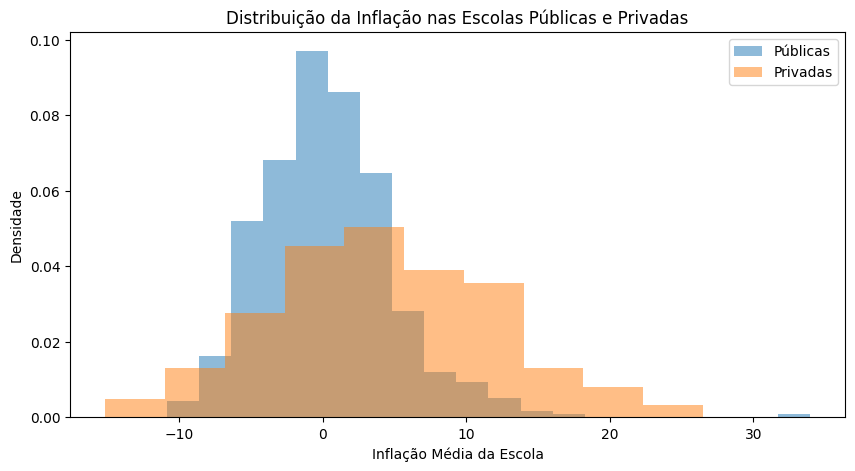

In [8]:
inflacao_pub_means = escolas_det.loc[escolas_det["escola_pubpriv"] == "PUB", "INF_RESIDUAL"]
inflacao_priv_means = escolas_det.loc[escolas_det["escola_pubpriv"] == "PRI", "INF_RESIDUAL"]

num_escolas_publicas = len(inflacao_pub_means)
num_escolas_privadas = len(inflacao_priv_means)

bin_width_pub = 1/np.sqrt(num_escolas_publicas)
bin_width_priv = 1/np.sqrt(num_escolas_privadas)
bins_pub = int((inflacao_pub_means.max() - inflacao_pub_means.min()) / bin_width_pub / 50)
bins_priv = int((inflacao_priv_means.max() - inflacao_priv_means.min()) / bin_width_priv / 50)

print("Número de escolas públicas: ", num_escolas_publicas)
print("Número de escolas privadas: ", num_escolas_privadas)
print("Número de bins para escolas públicas: ", bins_pub)
print("Número de bins para escolas privadas: ", bins_priv)

## Plot histogramas
plt.figure(figsize=(10, 5))
plt.hist(inflacao_pub_means, bins=bins_pub, alpha=0.5, label='Públicas', density=True)
plt.hist(inflacao_priv_means, bins=bins_priv, alpha=0.5, label='Privadas', density=True)
plt.xlabel("Inflação Média da Escola")
plt.ylabel("Densidade")
plt.title("Distribuição da Inflação nas Escolas Públicas e Privadas")
plt.legend()

## Distritos, concelhos

In [9]:
district_stats = escolas_det.groupby(["escola_distrito", "escola_distrito_descr"], observed=True).apply(agg_func).reset_index()
council_stats = escolas_det.groupby(["escola_concelho", "escola_concelho_descr", "escola_distrito"], observed=True).apply(agg_func).reset_index()

district_pubpriv_stats = escolas_det.groupby(["escola_distrito", "escola_pubpriv", "escola_distrito_descr"], observed=True).apply(agg_func).reset_index()
council_pubpriv_stats = escolas_det.groupby(["escola_concelho", "escola_pubpriv", "escola_concelho_descr", "escola_distrito"], observed=True).apply(agg_func).reset_index()


In [10]:
council_stats[council_stats["escola_distrito"] == 13].sort_values(by="INF_RESIDUAL")
council_pubpriv_stats[(council_pubpriv_stats["escola_distrito"] == 13)].sort_values(by="INF_RESIDUAL")

,escola_concelho,escola_pubpriv,escola_concelho_descr,escola_distrito,INF_RESIDUAL,INF_RESIDUAL_STD,NSAMPLES
319,18.0,PUB,Trofa,13.0,-4.196584,19.363599,3485.0
258,13.0,PUB,PÃ³voa de Varzim,13.0,-2.484049,18.424076,11435.0
162,8.0,PUB,Matosinhos,13.0,-2.313305,18.446597,16049.0
120,6.0,PUB,Maia,13.0,-0.382299,18.770240,14778.0
184,9.0,PUB,PaÃ§os de Ferreira,13.0,-0.330530,18.738385,7858.0
33,2.0,PUB,BaiÃ£o,13.0,0.074314,18.893872,1684.0
203,10.0,PUB,Paredes,13.0,0.112810,19.054743,9785.0
101,5.0,PUB,Lousada,13.0,0.150059,18.158112,6531.0
308,16.0,PUB,Vila do Conde,13.0,0.172264,18.032895,8218.0
241,12.0,PUB,Porto,13.0,0.811667,19.051179,25645.0


### Let's try to put it on the map

In [11]:
gdf = gpd.read_file("data_geo/Continente_CAOP2024_1.gpkg", layer="cont_distritos")
print(gdf.columns)

Index(['dt', 'distrito', 'nuts1', 'area_ha', 'perimetro_km', 'n_municipios',
       'n_freguesias', 'geometry'],
      dtype='object')


In [12]:
def normalize_name(s):
    if pd.isna(s):
        return s
    s = str(s)

    s = unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ascii")
    return s.upper().strip()

district_stats["distrito_norm"] = district_stats["escola_distrito_descr"].apply(normalize_name)
gdf["distrito_norm"] = gdf["distrito"].apply(normalize_name)

In [ ]:
#enough to add once
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["BRAGANCA"])
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["EVORA"])
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["SANTAREM"])
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["SETUBAL"])
district_stats["distrito_norm"] = district_stats["distrito_norm"].cat.add_categories(["R. A. ACORES"])

In [16]:
district_stats.loc[district_stats["distrito_norm"] == "BRAGANAA", "distrito_norm"] = "BRAGANCA"
district_stats.loc[district_stats["distrito_norm"] == "AVORA", "distrito_norm"] = "EVORA"
district_stats.loc[district_stats["distrito_norm"] == "SANTARAM", "distrito_norm"] = "SANTAREM"
district_stats.loc[district_stats["distrito_norm"] == "SETAOBAL", "distrito_norm"] = "SETUBAL"
district_stats.loc[district_stats["distrito_norm"] == "R. A. AAORES", "distrito_norm"] = "R. A. ACORES"
district_stats

,escola_distrito,escola_distrito_descr,INF_RESIDUAL,INF_RESIDUAL_STD,NSAMPLES,distrito_norm
0,1.0,Aveiro,1.260501,18.415620,94546.0,AVEIRO
1,2.0,Beja,-1.487053,18.250463,14489.0,BEJA
2,3.0,Braga,1.916455,19.111115,122386.0,BRAGA
3,4.0,BraganÃ§a,1.711366,19.364610,14454.0,BRAGANCA
4,5.0,Castelo Branco,-0.354028,18.083966,20700.0,CASTELO BRANCO
5,6.0,Coimbra,-0.829805,18.268316,54513.0,COIMBRA
6,7.0,Ãvora,1.043622,18.345973,23670.0,EVORA
7,8.0,Faro,-1.789520,18.797193,49395.0,FARO
8,9.0,Guarda,1.672786,18.939510,18602.0,GUARDA
9,10.0,Leiria,-2.733872,17.801418,59329.0,LEIRIA


In [17]:
mapdf = gdf.merge(
    district_stats[["distrito_norm", "INF_RESIDUAL"]],
    on="distrito_norm",
    how="left",
    validate="one_to_one"  # check that each district matches uniquely
)

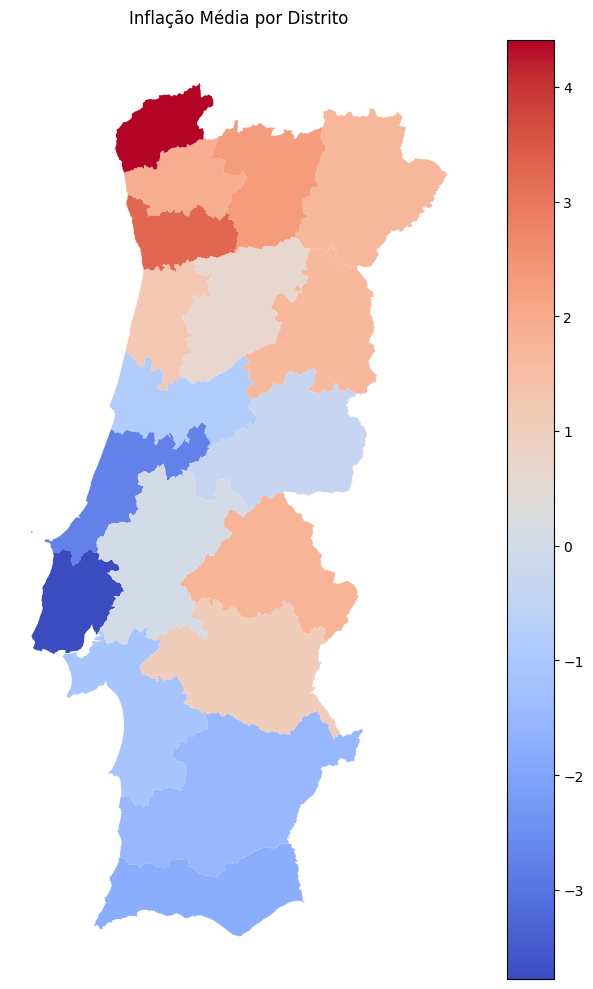

In [18]:
ax = mapdf.plot(column="INF_RESIDUAL", cmap="coolwarm", legend=True, figsize=(8, 10), missing_kwds={"color": "lightgrey", "label": "No data", "hatch": "///"})
ax.set_title("Inflação Média por Distrito", pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

#### Other variables

In [23]:
district_stats['INF_RESIDUAL_PUB'] = district_pubpriv_stats.loc[district_pubpriv_stats["escola_pubpriv"] == "PUB"].set_index("distrito_norm")["INF_RESIDUAL"]
district_stats['INF_RESIDUAL_PRI'] = district_pubpriv_stats.loc[district_pubpriv_stats["escola_pubpriv"] == "PRI"].set_index("distrito_norm")["INF_RESIDUAL"]
district_stats['INF_RESIDUAL_DIFF'] = - district_stats['INF_RESIDUAL_PUB'] + district_stats['INF_RESIDUAL_PRI']

KeyError: "None of ['distrito_norm'] are in the columns"

## Trying the islands

In [22]:
gdf_acores_oriental = gpd.read_file("data_geo/ArqAcores_GCentral_GOriental_CAOP2024_1.gpkg", layer = 'raa_cen_ori_distritos')
gdf_acores_ocidental = gpd.read_file("data_geo/ArqAcores_GOcidental_CAOP2024_1.gpkg", layer = 'raa_oci_distritos')
gdf_madeira = gpd.read_file("data_geo/ArqMadeira_CAOP2024_1.gpkg", layer = 'ram_distritos')

gdf_acores_ocidental = gdf_acores_ocidental.to_crs(4326)
gdf_acores_oriental = gdf_acores_oriental.to_crs(4326)
az_all = pd.concat([gdf_acores_oriental, gdf_acores_ocidental], ignore_index=True)
az_one = az_all.dissolve().assign(distrito="R. A. ACORES")
mad_one = gdf_madeira.dissolve().assign(distrito="R. A. MADEIRA")

xmin, ymin, xmax, ymax = gdf.total_bounds

# Place Madeira near Algarve bottom-left; place Azores in left “white space”
# Offsets are in meters; tweak to taste.
def move_and_scale(gdf, dx, dy, s=0.9):
    # scale around each geometry centroid (slight shrink helps composition)
    g = gdf.copy()
    g["geometry"] = g["geometry"].apply(lambda geom: scale(geom, xfact=s, yfact=s, origin="center"))
    g["geometry"] = g["geometry"].translate(xoff=dx, yoff=dy)
    return g

# Compute rough centers to build offsets
az_cx, az_cy = az_one.geometry.centroid.x.iloc[0], az_one.geometry.centroid.y.iloc[0]
mad_cx, mad_cy = mad_one.geometry.centroid.x.iloc[0], mad_one.geometry.centroid.y.iloc[0]

# Target positions (example): 
#   - Madeira: a bit left of mainland xmin, below Algarve
#   - Azores : further left, roughly mid-height of mainland
mad_target_x = xmin - 200_000
mad_target_y = ymin - 120_000
az_target_x  = xmin - 600_000
az_target_y  = (ymin + ymax)/2

mad2 = move_and_scale(mad_one, dx=mad_target_x - mad_cx, dy=mad_target_y - mad_cy, s=0.85)
az2  = move_and_scale(az_one,  dx=az_target_x  - az_cx,  dy=az_target_y  - az_cy,  s=0.85)

# --- Combine for plotting & merge your stats ---
full = pd.concat([gdf, az2, mad2], ignore_index=True)

/var/folders/vg/b1j027cd3vjcqjtbx_ggb3p40000gn/T/ipykernel_77911/3497780422.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  az_cx, az_cy = az_one.geometry.centroid.x.iloc[0], az_one.geometry.centroid.y.iloc[0]


ValueError: Cannot determine common CRS for concatenation inputs, got ['ETRS89 / Portugal TM06', 'WGS 84', 'PTRA08 / UTM zone 28N']. Use `to_crs()` to transform geometries to the same CRS before merging.

In [94]:
mapdf_with_islands = gdf_full.merge(
    district_stats[["distrito_norm", "INF_RESIDUAL"]],
    on="distrito_norm",
    how="left",
    validate="one_to_one"  # check that each district matches uniquely
)

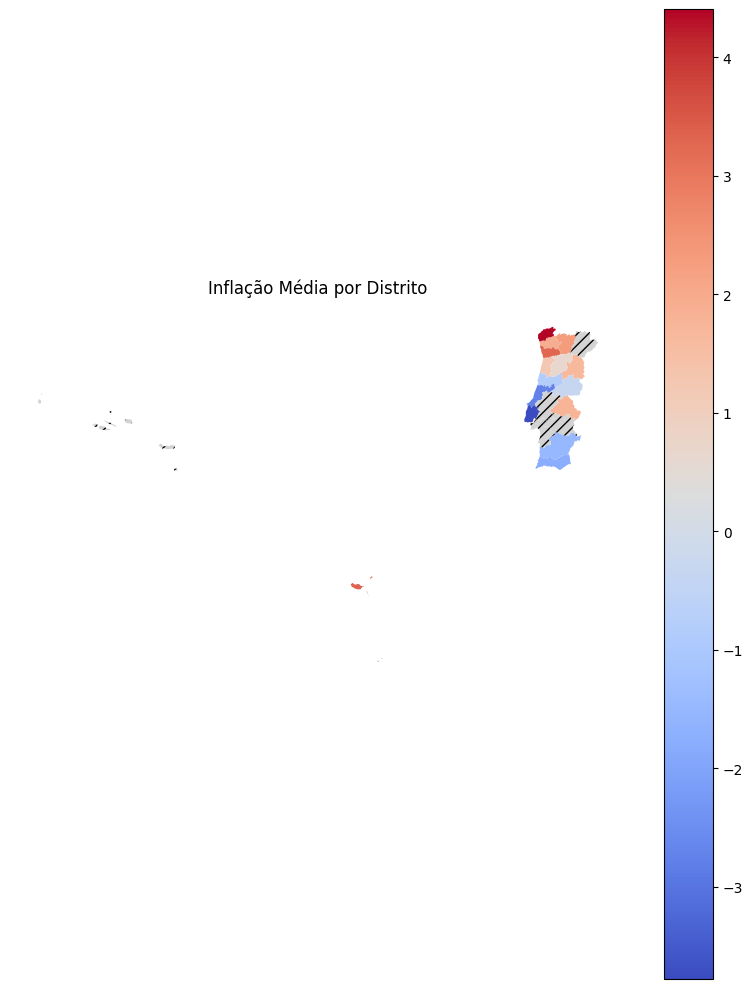

In [95]:
ax = mapdf_with_islands.plot(column="INF_RESIDUAL", cmap="coolwarm", legend=True, figsize=(8, 10), missing_kwds={"color": "lightgrey", "label": "No data", "hatch": "///"})
ax.set_title("Inflação Média por Distrito", pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Let's draw the same map for the other interesting variables

## Exploration

In [41]:
district_pubpriv_stats

,escola_distrito,escola_pubpriv,INF_RESIDUAL,INF_RESIDUAL_STD,NSAMPLES
0,1.0,PRI,4.398944,18.249548,10438.0
1,1.0,PUB,0.871013,18.398930,84108.0
2,2.0,PRI,0.504448,17.350548,709.0
3,2.0,PUB,-1.589518,18.290303,13780.0
4,3.0,PRI,7.327776,19.213909,18423.0
5,3.0,PUB,0.957530,18.932286,103963.0
6,4.0,PRI,-2.517840,20.757856,349.0
7,4.0,PUB,1.816009,19.317916,14105.0
8,5.0,PRI,-0.252838,18.495161,833.0
9,5.0,PUB,-0.358271,18.066984,19867.0


In [33]:
#subset = escolas_det[(escolas_det["escola_distrito"] == 11) & (escolas_det["escola_concelho"] == 6)]
subset = escolas_det[(escolas_det["escola_distrito"] == 2)]